In [1]:
import keras 
import tensorflow as tf
import keras.backend.tensorflow_backend as K
from PIL import Image
from imutils import paths
from os import path
from keras.optimizers import Adam,RMSprop
import pandas as pd
keras.__version__
IMAGE_DIMS = (375,250,3)
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array

In [3]:
date_arr = np.load('./new_date_arr.npy',allow_pickle=True)
dust_arr = np.load('./ultra_PM_avg_7.npy',allow_pickle=True)
wind_arr = np.load('./wind_arr.npy',allow_pickle=True)
humi_arr = np.load('./humi_arr.npy',allow_pickle=True)

In [4]:
import time

start = time.time() 
imagePaths = sorted(list(paths.list_images('./dataset/image')))
image_arr = []

for i in imagePaths:
    img_name = int(path.splitext(path.basename(i))[0])
    
    if img_name in date_arr :
        image = Image.open(i)
        image_crop = image.crop([380,0,600,200])
        image_crop = image_crop.resize((IMAGE_DIMS[0],IMAGE_DIMS[1]))
        image = image.resize((IMAGE_DIMS[0],IMAGE_DIMS[1]))
        image = np.concatenate((image_crop,image),axis=2)
        image = img_to_array(image)
        image_arr.append(image)
#         image = Image.open(i)
#         image = image.resize((IMAGE_DIMS[0],IMAGE_DIMS[1]))
#         image = img_to_array(image)
#         image_arr.append(image)
        
image_arr = np.array(image_arr, dtype="float") / 255.0        
print("[INFO] data matrix: {} images ({:.2f}MB)".format(len(imagePaths), image_arr.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 18126 images (49025.39MB)


In [5]:
from sklearn.utils import shuffle



con_data_img = image_arr
con_data_val = dust_arr

print(wind_arr.shape)
con_data_wea = np.concatenate([wind_arr.reshape(len(wind_arr),1),humi_arr.reshape(len(humi_arr),1)], axis=1)


# 국내는 PM2.5이 16이상이면 보통
# for i in range(0,dustvalue.shape[0]):
#     if int(dustvalue[i]) > 0 :
#         con_data_img.append(data[i])
#         con_data_val.append(dustvalue[i])
#         con_data_wea.append(add_info[i])
        
# con_data_img, con_data_val, con_data_wea = shuffle(np.array(con_data_img), np.array(con_data_val), np.array(con_data_wea), random_state=0)
# con_data_img = np.array(con_data_img)
# con_data_val = np.array(con_data_val)
# con_data_wea = np.array(con_data_wea)

num = int(con_data_img.shape[0]*0.85)

train_img = con_data_img[:num]
train_val = con_data_val[:num]
train_wea = con_data_wea[:num]

test_img = con_data_img[num:]
test_val = con_data_val[num:]
test_wea = con_data_wea[num:]

print(con_data_img.shape)
print(train_img.shape)
print(test_img.shape)

print(con_data_img.shape)
print(con_data_val.shape)
print(con_data_wea.shape)


(11156,)
(11156, 250, 375, 6)
(9482, 250, 375, 6)
(1674, 250, 375, 6)
(11156, 250, 375, 6)
(11156,)
(11156, 2)


In [6]:
# import the necessary packages
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, GRU, Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

chanDim=-1
model = Sequential()

# CONV => RELU => POOL
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(IMAGE_DIMS[1], IMAGE_DIMS[0],6)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())


image_input = Input(shape=(IMAGE_DIMS[1], IMAGE_DIMS[0],6))
encoded_image = model(image_input)

# 다음은 문제를 벡터로 인코딩할 숫자 모델을 정의합니다
numeric_input = Input(shape=(2,))
embedded_numeric = Embedding(input_dim=100, output_dim=128, input_length=2)(numeric_input)

# numeric_input2 = Dense(256, activation="linear")(embedded_numeric)
# print(embedded_numeric.shape)

#numeric_input2 = GRU(256)(embedded_numeric)
numeric_input2 = LSTM(128)(embedded_numeric)
# print(numeric_input2.shape)


# numeric_input = Input(shape=(8,), dtype='float32')
# numeric_input1 = Dense(1000,activation='linear')(numeric_input)
# numeric_input2 = Dense(100,activation='linear')(numeric_input1)

# 질문 벡터와 이미지 벡터를 연결해 봅시다:
merged = keras.layers.concatenate([encoded_image, numeric_input2],axis=-1)

output = Dense(1)(merged)

# 그리고 상층의 로지스틱 회귀를 수치에 대해 학습시킵니다:
# output = Dense(1024, activation='softmax')(merged)
# output = Dense(128, activation='softmax')(output)
# output = Dense(1)(output)
# 다음은 최종 모델입니다:
model = Model(inputs=[image_input, numeric_input], outputs=output)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
#opt = RMSprop(lr=0.005, rho=0.9, epsilon=None, decay=0.0)
opt = Adam(lr=0.002, epsilon=None, decay=0.0)
model.compile(loss="mse", optimizer=opt,metrics=["accuracy"])
# logcosh, mes, 
H = model.fit([train_img,train_wea], train_val ,batch_size=48, epochs=100)


print("[INFO] serializing network...")
model.save('lstm-roi-ultra-PM-7.model')



Instructions for updating:
Use tf.cast instead.
Epoch 1/100
9482/9482 [==============================] - 50s 5ms/step - loss: 132.7817 - acc: 0.0089
Epoch 2/100
9482/9482 [==============================] - 41s 4ms/step - loss: 67.1761 - acc: 0.0124
Epoch 3/100
9482/9482 [==============================] - 41s 4ms/step - loss: 64.6800 - acc: 0.0111
Epoch 4/100
9482/9482 [==============================] - 41s 4ms/step - loss: 60.3586 - acc: 0.0118
Epoch 5/100
9482/9482 [==============================] - 41s 4ms/step - loss: 52.9762 - acc: 0.0137
Epoch 6/100
9482/9482 [==============================] - 41s 4ms/step - loss: 55.7074 - acc: 0.0133
Epoch 7/100
9482/9482 [==============================] - 41s 4ms/step - loss: 50.2583 - acc: 0.0137
Epoch 8/100
9482/9482 [==============================] - 41s 4ms/step - loss: 44.1570 - acc: 0.0118
Epoch 9/100
9482/9482 [==============================] - 41s 4ms/step - loss: 44.5087 - acc: 0.0121
Epoch 10/100
9482/9482 [===========================

9482/9482 [==============================] - 41s 4ms/step - loss: 4.2642 - acc: 0.0472
Epoch 80/100
9482/9482 [==============================] - 41s 4ms/step - loss: 4.5888 - acc: 0.0455
Epoch 81/100
9482/9482 [==============================] - 41s 4ms/step - loss: 3.6114 - acc: 0.0518
Epoch 82/100
9482/9482 [==============================] - 41s 4ms/step - loss: 2.9663 - acc: 0.0549
Epoch 83/100
9482/9482 [==============================] - 41s 4ms/step - loss: 3.0505 - acc: 0.0541
Epoch 84/100
9482/9482 [==============================] - 41s 4ms/step - loss: 3.3724 - acc: 0.0540
Epoch 85/100
9482/9482 [==============================] - 41s 4ms/step - loss: 3.8798 - acc: 0.0519
Epoch 86/100
9482/9482 [==============================] - 41s 4ms/step - loss: 3.8964 - acc: 0.0529
Epoch 87/100
9482/9482 [==============================] - 41s 4ms/step - loss: 3.5666 - acc: 0.0508
Epoch 88/100
9482/9482 [==============================] - 41s 4ms/step - loss: 3.3671 - acc: 0.0577
Epoch 89/100


In [8]:
print(image_arr.shape)
print(dust_arr.shape)

print(wind_arr.shape)
print(humi_arr.shape)

print(test_img.shape)
print(test_wea.shape)

print(model.predict([test_img, test_wea]))

y_pred = np.squeeze(np.round(model.predict([test_img, test_wea]).astype(np.int64)))

print(test_val.shape)
print(y_pred.shape)

(11156, 250, 375, 6)
(11156,)
(11156,)
(11156,)
(1674, 250, 375, 6)
(1674, 2)
[[12.123038 ]
 [12.288499 ]
 [12.212509 ]
 ...
 [ 6.7737184]
 [ 5.603776 ]
 [ 5.9437547]]
(1674,)
(1674,)


In [9]:
# print(con_data_val.shape)
# print(train_val.shape)
# print(test_val.shape)
print(con_data_img.shape)
print(con_data_val.shape)
print(con_data_wea.shape)

(11156, 250, 375, 6)
(11156,)
(11156, 2)


In [10]:
RMSE = mean_squared_error(test_val.astype(np.int64), y_pred)**0.5
R2SCORE = r2_score(test_val.astype(np.int64), y_pred)

print("RMSE 는 : " , RMSE)
print("R2SCORE 는 : ", R2SCORE)

RMSE 는 :  11.678693237974635
R2SCORE 는 :  -0.08941793518028551


Text(70, 50, 'R-squared = -0.09')

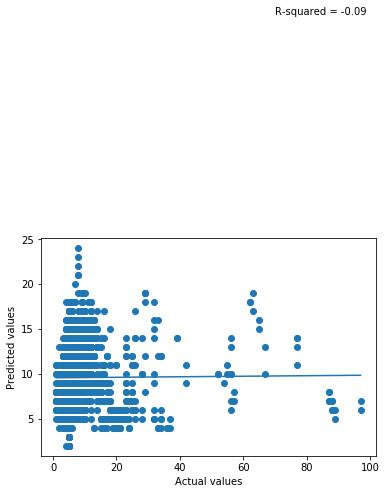

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

test_val=np.squeeze(test_val.astype(np.int64))

plt.scatter(test_val,y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.plot(np.unique(test_val), np.poly1d(np.polyfit(test_val, y_pred, 1))(np.unique(test_val)))

plt.text(70, 50, 'R-squared = %0.2f' % R2SCORE)

In [12]:
np.round(test_val.astype(np.int64))
np.where(test_val >50)

(array([ 647,  648,  649,  650,  651,  652,  653,  654,  655,  656,  657,
         658,  659,  660,  661,  662,  663,  664, 1056, 1057, 1058, 1231,
        1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242,
        1243, 1244, 1245, 1246], dtype=int64),)

예측값 :  5
실제값 :  89


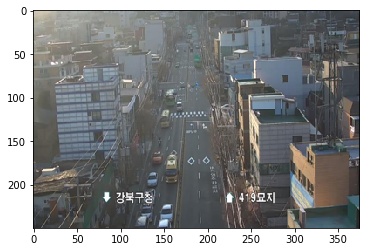

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
i=1241

plt.imshow(test_img[i][:,:,3:])
print("예측값 : ", y_pred[i])
print("실제값 : ", test_val[i])